<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Starter**

In this notebook we will learn how to use [RAFT](https://arxiv.org/pdf/2003.12039.pdf) or Recurrent All-Pairs Field Transforms for Optical Flow

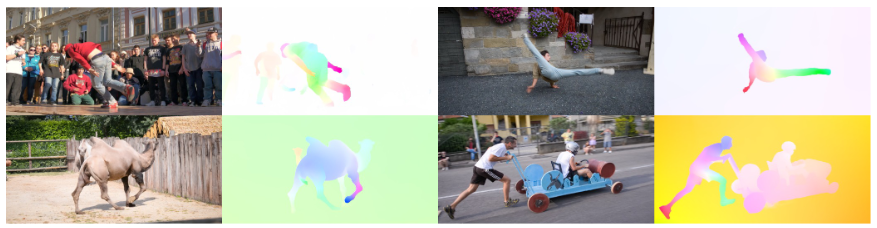

## **RAFT Models**

RAFT has several pretrained models:
 - raft-chairs - trained on FlyingChairs
 - raft-things - trained on FlyingChairs + FlyingThings
 - raft-sintel - trained on FlyingChairs + FlyingThings + Sintel + KITTI
 - raft-kitti - raft-sintel finetuned on only KITTI
 - raft-small - trained on FlyingChairs + FlyingThings

Clone the repo and import libraries

In [1]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 2 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 6.98 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Add RAFT core to path

In [3]:
sys.path.append('RAFT/core')

Get demo frames

In [4]:
# !wget https://github.com/itberrios/CV_projects/blob/main/RAFT/test_images/fan_frame_1.png
# !wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_1.png

In [6]:
import subprocess

env = os.environ.copy()
frame_paths = []
for i in range(75):
    cmd = f"wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_{i}.png"
    subprocess.run(cmd, shell=True, env=env)

    frame_paths.append(f"fan_frame_{i}.png")

In [7]:
frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [8]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread('fan_frame_1.png')
frame2 = cv2.imread('fan_frame_2.png')
frame3 = cv2.imread('fan_frame_3.png')

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB)

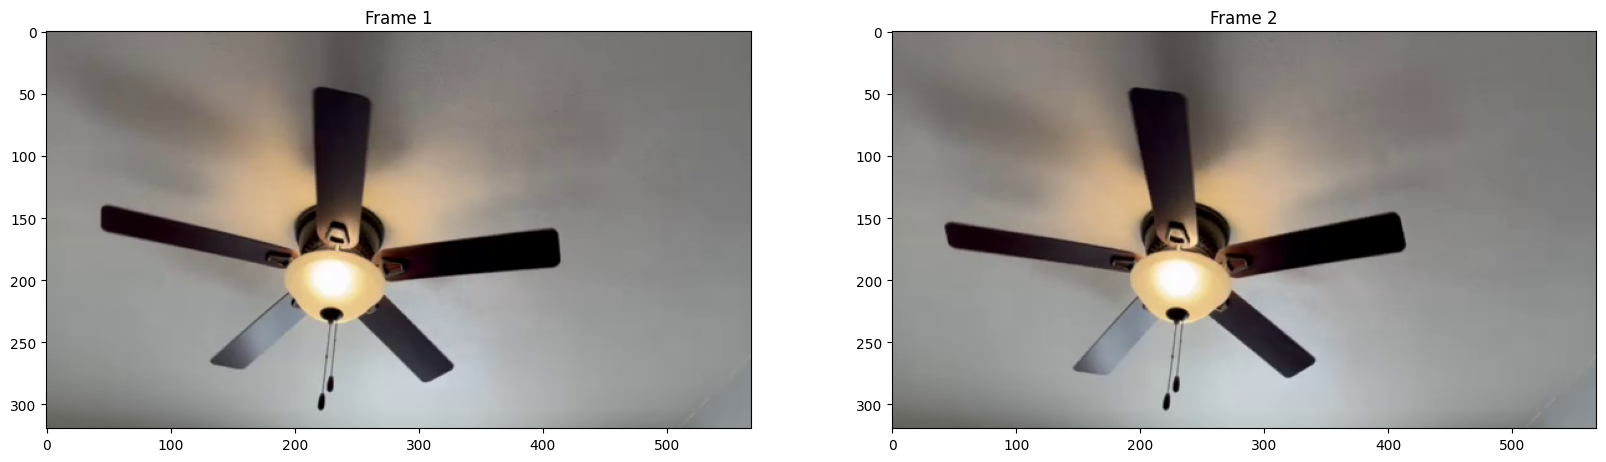

In [9]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(frame1)
ax[0].set_title("Frame 1")
ax[1].imshow(frame2)
ax[1].set_title("Frame 2");

## Download models

In [17]:
%cd RAFT
!./download_models.sh
# !python demo.py --model=models/raft-things.pth --path=demo-frames
%cd ..

/content/RAFT
--2023-10-01 16:27:53--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6023:15::a27d:430f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.81.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  12.9MB/s    in 6.6s    

2023-10-01 16:28:01 (11.8 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/content


### Helper functions

In [18]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

### Load Model

In [19]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

### Predict Optical Flow

In [20]:
flow_low, flow_up = inference(model, frame1, frame2, device='cuda')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
flow_low.shape, flow_up.shape

(torch.Size([1, 2, 40, 71]), torch.Size([1, 2, 320, 568]))

### Display Results

In [22]:
flow_low_viz = get_viz(flow_low)
flow_up_viz = get_viz(flow_up)

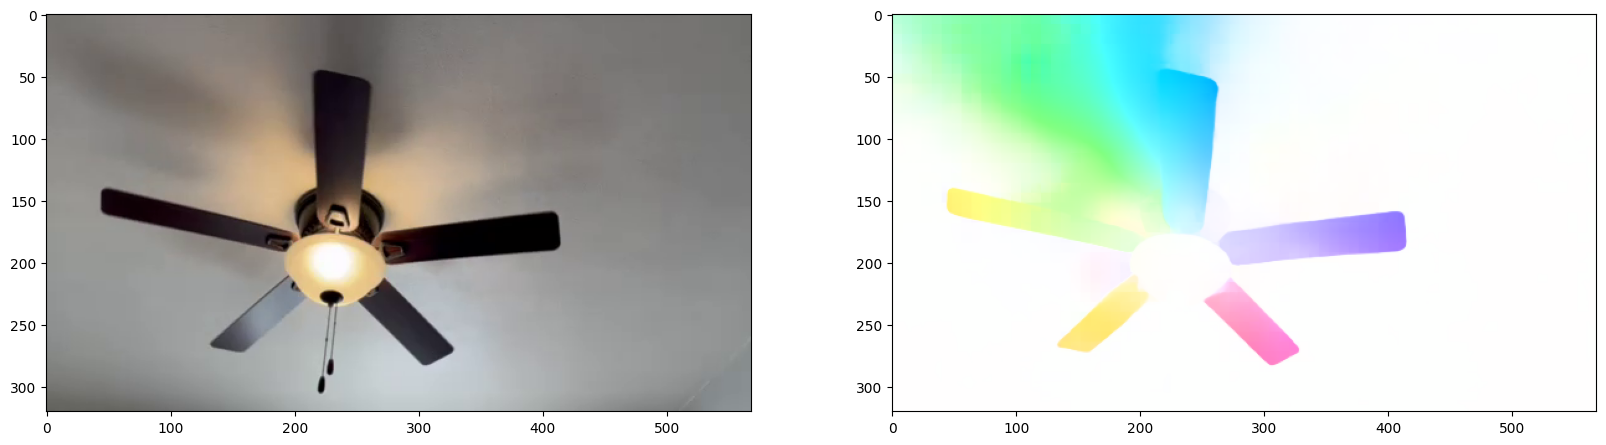

In [23]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(frame1)
ax1.imshow(flow_up_viz)
plt.show()

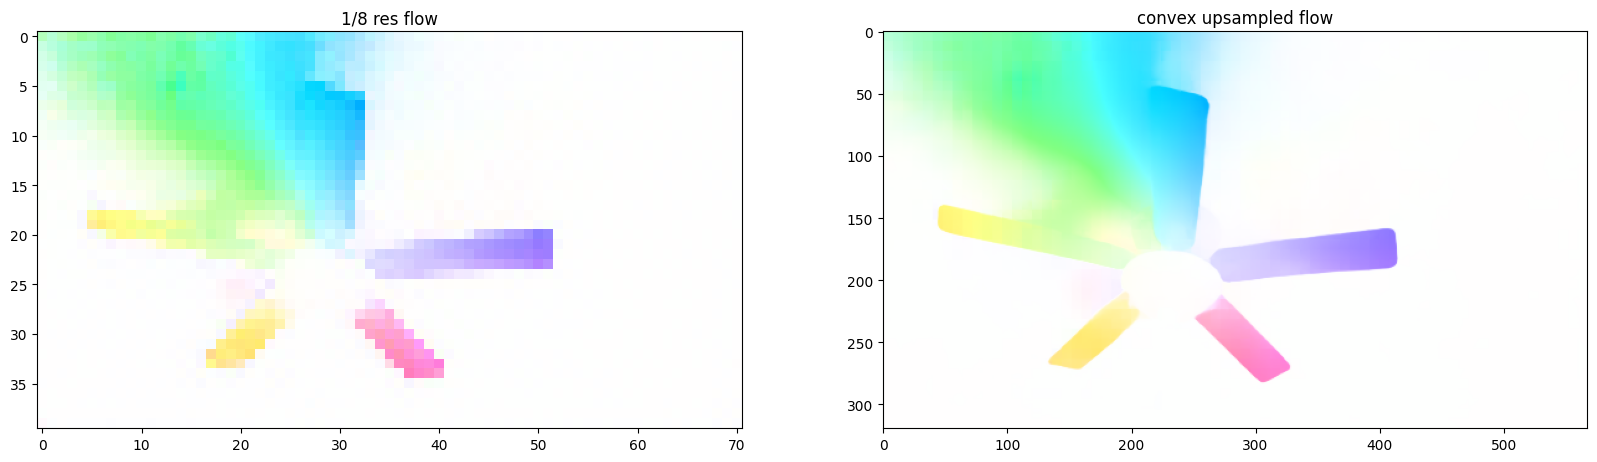

In [24]:
, itfrom matplotlib.colors import LogNorm

f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(flow_low_viz)
ax0.set_title('1/8 res flow')
ax1.imshow(flow_up_viz)
ax1.set_title('convex upsampled flow');

In [25]:
flow_iters = inference(model, frame1, frame2, device='cuda', iters=20, test_mode=False)

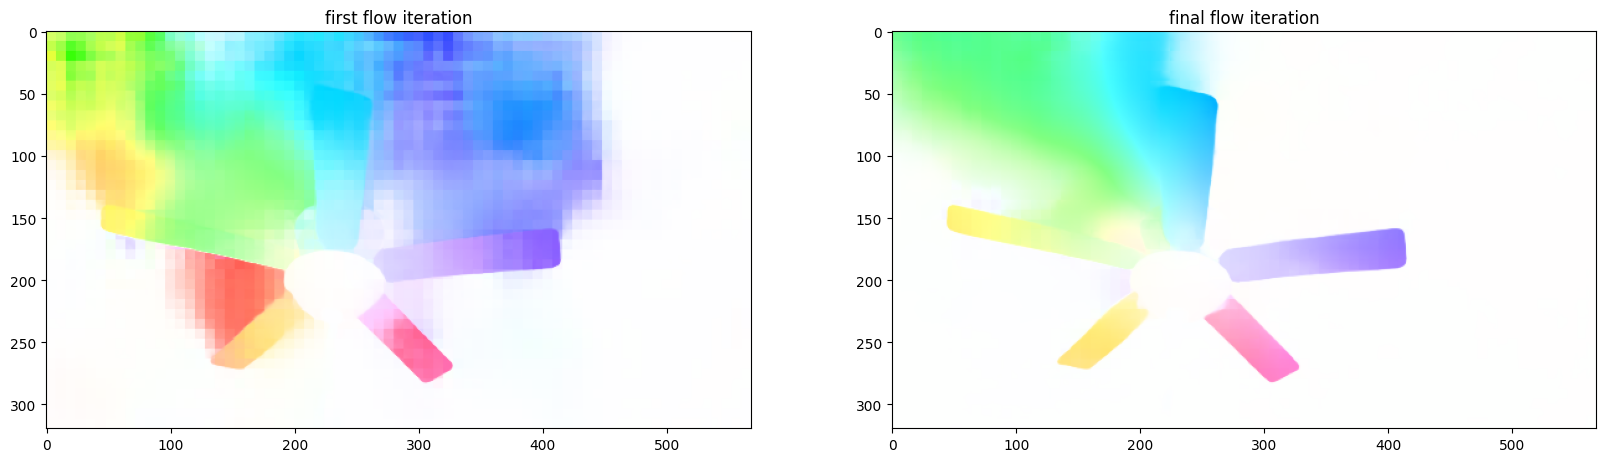

In [26]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

Save flow iters

In [ ]:
for i in range(0, len(flow_iters)):
    # cv2.imwrite(f"flow_iter_{i}.png", get_viz(flow_iters[i]))
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(get_viz(flow_iters[i]))
    plt.title(f"Iteration {i}")
    fig.savefig(f"flow_iter_{i}.png");

## **Estimate Flow with a Warm Start**

In [28]:
# get previous estimate at 1/8 res
flow_lo, flow_up = inference(model, frame1, frame2, device='cuda', pad_mode=None, iters=20, test_mode=True)

# 0 initialization
flow_lo_cold, flow_up_cold = inference(model, frame2, frame3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

# warm initialization
flow_lo_warm, flow_up_warm = inference(model, frame2, frame3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

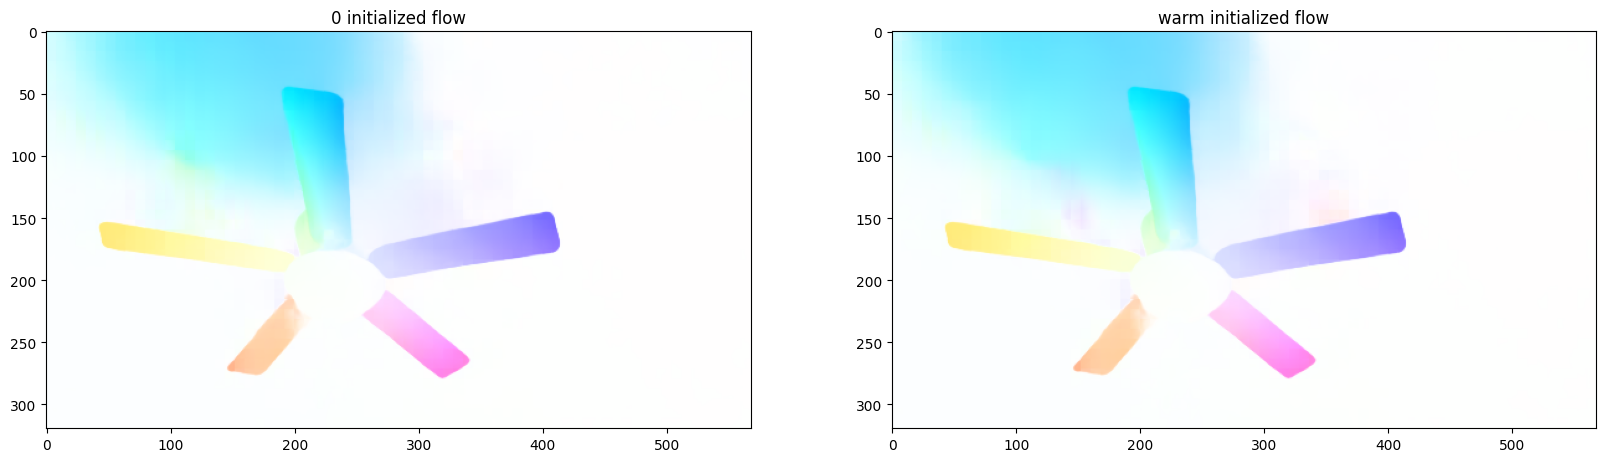

In [29]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_up_cold))
ax0.set_title('0 initialized flow')
ax1.imshow(get_viz(flow_up_warm))
ax1.set_title('warm initialized flow');

# **Make a GIF of the fan video**

In this section, we will estimate the flow of each frame using a warm start. In the previous estimations there is a lot of noise in the background of the fan. We will need to remove this noise in order to get good estimations.

Get warm-start flow estimates

In [200]:
# store results
unfiltered_flow_frames = []

for i in range(2, len(frame_paths)):
    # get frames
    frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2RGB)
    frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2RGB)
    frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)

    # get previous estimate at 1/8 res
    flow_lo, flow_up = inference(model, frame_1, frame_2, device='cuda', pad_mode=None, iters=20, test_mode=True)

    # 0 initialization
    flow_lo_cold, flow_up_cold = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

    # warm initialization
    flow_lo_warm, flow_up_warm = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

    # save results
    if i == 2:
      unfiltered_flow_frames.append(flow_up)

    unfiltered_flow_frames.append(flow_up_warm)

Display results

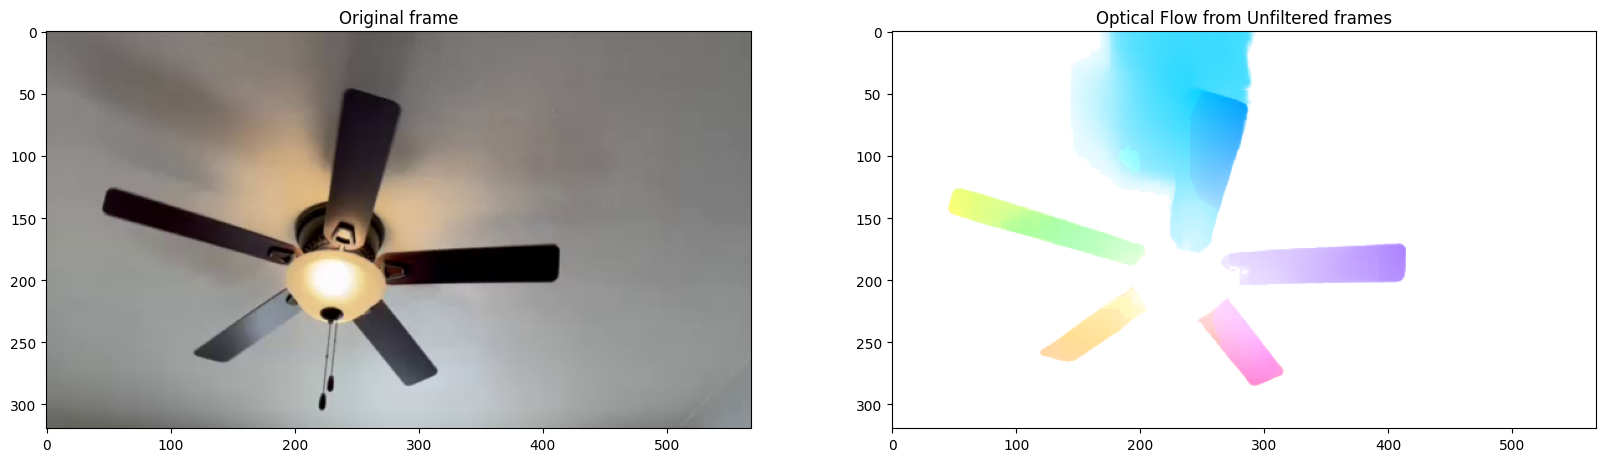

In [201]:
idx = 0

warm = unfiltered_flow_frames[idx].clone()
warm[torch.abs(warm) < 2] = 0

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)

f, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].imshow(og_frame)
ax[0].set_title('Original frame')
ax[1].imshow(get_viz(warm))
ax[1].set_title('Optical Flow from Unfiltered frames');

## **Second Attempt with Filtered Frames**

Now we will show how some basic filtering can make a big difference for flow estimation

Code to filter image

In [202]:
def filter_image(frame, iters=1):

    filtered = frame.copy()

    for i in range(iters):
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(3,3), sigmaX=3)
      filtered = cv2.Laplacian(filtered, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(5,5), sigmaX=5)
      filtered[filtered < 10] = 0
      filtered = cv2.convertScaleAbs(filtered, dst=None, alpha=10, beta=0)

    return filtered

In [203]:
# store results
cold_flow_frames = []
flow_frames = []

for i in range(2, len(frame_paths)):
    # get frames
    frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2GRAY)
    frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2GRAY)

    # Filter
    frame_1 = filter_image(frame_1, iters=2)
    frame_2 = filter_image(frame_2, iters=2)
    frame_3 = filter_image(frame_3, iters=2)

    # repeat last 3 dimensions
    frame_1 = np.repeat(frame_1[:, :, None], 3, axis=-1)
    frame_2 = np.repeat(frame_2[:, :, None], 3, axis=-1)
    frame_3 = np.repeat(frame_3[:, :, None], 3, axis=-1)

    # get previous estimate at 1/8 res
    flow_lo, flow_up = inference(model, frame_1, frame_2, device='cuda', pad_mode=None, iters=20, test_mode=True)

    # 0 initialization
    flow_lo_cold, flow_up_cold = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

    # warm initialization
    flow_lo_warm, flow_up_warm = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

    # save results
    if i == 2:
      flow_frames.append(flow_up)
      cold_flow_frames.append(flow_up)

    flow_frames.append(flow_up_warm)
    cold_flow_frames.append(flow_up_cold)

### Check and filter results

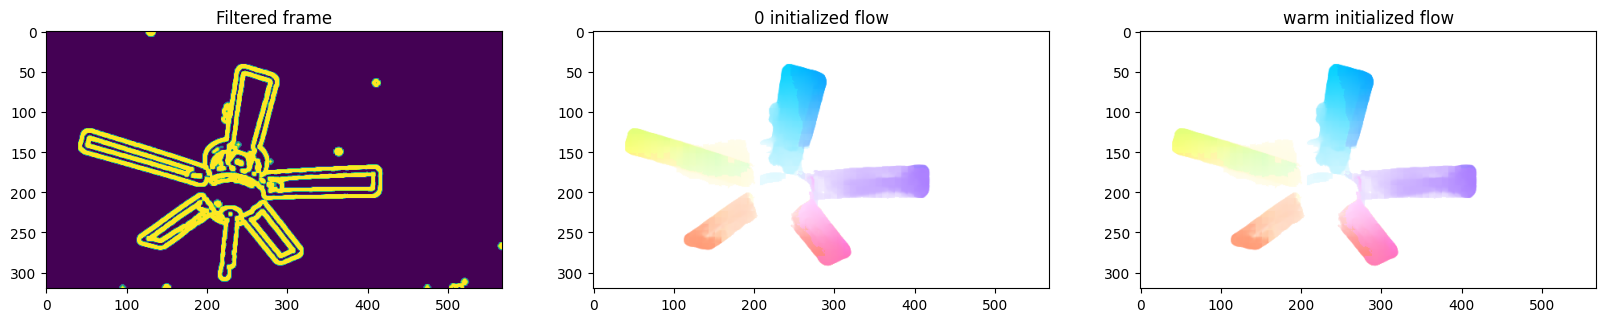

In [204]:
# filter results

idx = 0
cold = cold_flow_frames[idx].clone()
cold[torch.abs(cold) < 2] = 0

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < 2] = 0

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

f, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(cold))
ax[1].set_title('0 initialized flow')
ax[2].imshow(get_viz(warm))
ax[2].set_title('warm initialized flow');

### Display everything

In [205]:
len(frame_paths)

75

In [206]:
len(unfiltered_flow_frames), len(flow_frames)

(74, 74)

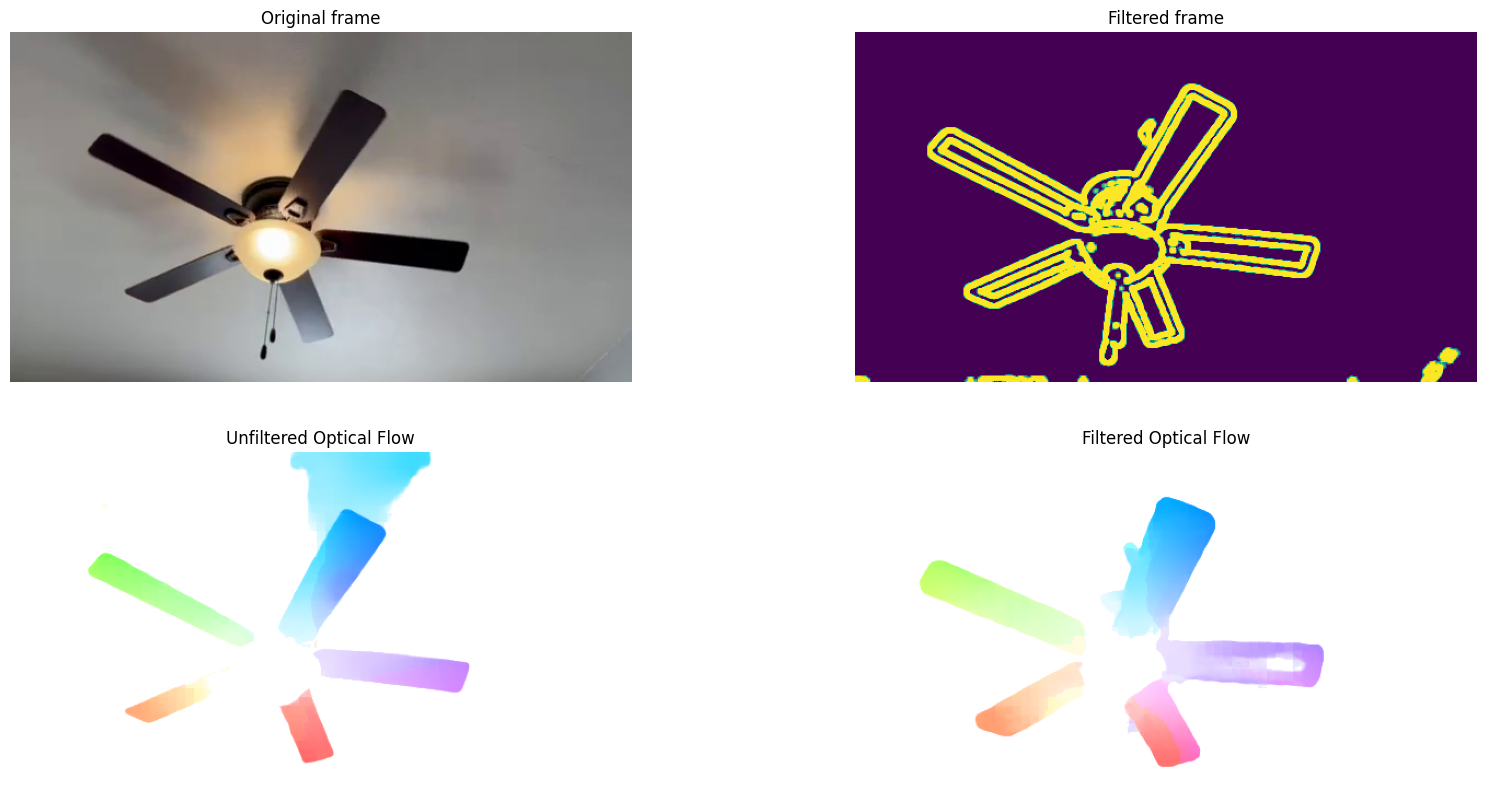

In [212]:
idx = 70
thresh = 2

un_flow = unfiltered_flow_frames[idx].clone()
un_flow[torch.abs(un_flow) < thresh] = 0

flow = flow_frames[idx + 1].clone()
flow[torch.abs(flow) < thresh] = 0

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].imshow(og_frame)
ax[0, 0].set_title('Original frame')
ax[0, 0].axis(False)

ax[0, 1].imshow(frame)
ax[0, 1].set_title('Filtered frame')
ax[0, 1].axis(False)

ax[1, 0].imshow(get_viz(un_flow))
ax[1, 0].set_title('Unfiltered Optical Flow');
ax[1, 0].axis(False);

ax[1, 1].imshow(get_viz(flow))
ax[1, 1].set_title('Filtered Optical Flow');
ax[1, 1].axis(False);

In [213]:
from PIL import Image
from glob import glob


def create_gif_from_images(save_path, image_path, ext):
    ''' creates a GIF from a folder of images
        Inputs:
            save_path (str) - path to save GIF
            image_path (str) - path where images are located
            ext (str) - extension of the images
        Outputs:
            None

        Update:
            Add functionality for multiple extensions
    '''
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))

    pil_images = [Image.open(im_path ) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

In [216]:
thresh = 2


for i in range(len(flow_frames) - 1):

  un_flow = unfiltered_flow_frames[i].clone()
  un_flow[torch.abs(un_flow) < thresh] = 0

  flow = flow_frames[i + 1].clone()
  flow[torch.abs(flow) < thresh] = 0

  og_frame = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)
  frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
  frame = filter_image(frame)
  frame = filter_image(frame)

  fig, ax = plt.subplots(2, 2, figsize=(20, 10))

  ax[0, 0].imshow(og_frame)
  ax[0, 0].set_title('Original frame')
  ax[0, 0].axis(False)

  ax[0, 1].imshow(frame)
  ax[0, 1].set_title('Filtered frame')
  ax[0, 1].axis(False)

  ax[1, 0].imshow(get_viz(un_flow))
  ax[1, 0].set_title('Unfiltered Optical Flow');
  ax[1, 0].axis(False);

  ax[1, 1].imshow(get_viz(flow))
  ax[1, 1].set_title('Filtered Optical Flow');
  ax[1, 1].axis(False);

  fig.savefig(f"flow_gif_{i}.jpg");
  plt.close();


In [220]:
gif_frame_paths = sorted(glob('*.jpg'))
gif_frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
gif_path = 'flow.gif'

In [222]:
pil_images = [Image.open(im_path) for im_path in gif_frame_paths]
pil_images[0].save(gif_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)